# Bayesian Structural Time Series (BSTS)

:::{card} 

- Scott & Varian (2015) [Bayesian variable selection for nowcasting economic time series.](https://www.nber.org/books-and-chapters/economic-analysis-digital-economy/bayesian-variable-selection-nowcasting-economic-time-series)
- Scott & Varian (2014) [Predicting the present with Bayesian structural time series.](https://www.inderscienceonline.com/doi/abs/10.1504/IJMMNO.2014.059942)

:::


統計学者Steven Scottと経済学者Hal Varianが提案したnowcastingモデル（直近の予測や現時点の欠測値を予測することもできる）

説明変数が多次元の状態空間モデルで、Lassoのように説明変数の選択を行う仕組み（spike and slab事前分布）を導入している

### モデル

構造時系列モデル（状態空間モデル）

- 観測方程式：$y_t = Z_t^{\mathrm{T}} \alpha_t+\varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}\left(0, \sigma_t^2\right)$
- 状態方程式：$\alpha_{t+1} = T_t \alpha_t+R_t \eta_t, \quad \eta_t \sim \mathcal{N}\left(0, Q_t\right)$

### 状態の構成要素

#### 局所線形トレンド（local linear trend）

$$
\begin{aligned}
\mu_{t+1} & =\mu_t+\delta_t+\eta_{\mu, t}, & \eta_{\mu, t} \sim \mathcal{N}\left(0, \sigma_\mu^2\right) \\
\delta_{t+1} & =\delta_t+\eta_{\delta, t}, & \eta_{\delta, t} \sim \mathcal{N}\left(0, \sigma_\delta^2\right)
\end{aligned}
$$

- $\mu_t$：水準
- $\delta_t$：傾き

#### 季節成分（Seasonality）

$$
\gamma_{t+1}=-\sum_{s=0}^{S-2} \gamma_{t-s}+\eta_{\gamma, t}
$$

- $S$は季節数（例：$S=7$なら曜日効果）
- 総和がゼロになるように構成

#### 回帰成分（Regression Component）

静的または動的係数による回帰

$$
y_t=x_t^{\top} \beta_t+\varepsilon_t
$$

- 静的：$\beta_t = \beta$
- 動的：$\beta_{t+1} = \beta_t + \eta_{\beta,t}$


### Spike-and-Slab 事前分布

Spike-and-Slab事前分布はベイズ線形回帰などで変数選択に用いられるスパース事前分布

:::{admonition} Spike-and-Slab 事前分布

$$
p(\rho, \beta, 1/\sigma_\varepsilon^2)
= p(\rho)\, p(\sigma_\varepsilon^2 \mid \rho)\, p(\beta_\rho \mid \rho, \sigma_\varepsilon^2)
$$

- $\rho$ ：**変数選択ベクトル**。各説明変数 $x_j$ がモデルに含まれるか（$\rho_j=1$）含まれないか（$\rho_j=0$）を表す。すなわち、 $\rho_j=1$ のとき $\beta_j \neq 0$ となる。
- $\beta$ ：回帰係数ベクトル。各 $\beta_j$ は説明変数 $x_j$ の影響度を示す。
- $\sigma_\varepsilon^2$ ：残差（観測誤差）分散。時系列ノイズの強さを表す。

:::


#### $p(\rho)$ ：スパイク部分（変数選択）

各変数が選ばれる確率（inclusion probability）に関する事前分布。独立ベルヌーイ分布を仮定する。

スパイク部分では、各説明変数 $x_j$ がモデルに含まれるかをベルヌーイ確率変数で表します。

$$
p(\rho) = \prod_{j=1}^J \pi_j^{\rho_j} (1 - \pi_j)^{1 - \rho_j}
$$

ここで、$\pi_j$ は 変数 $j$ がモデルに含まれる事前確率で、一般には期待されるモデルサイズ $M$ に基づき、  

$$
\pi_j = \frac{M}{J}
$$  

のように設定される（ただし、特定変数を必ず含めたい場合は $\pi_j = 1$ とするなど調整可能）。


#### $p(\beta_\rho \mid \rho, \sigma_\varepsilon^2)$ ：スラブ部分（係数分布）

モデルに採用された変数（$\rho_j = 1$ のもの）の回帰係数ベクトル $\beta_\rho$ に対して、共役な正規分布を事前として与える。

$$
\beta_\rho \mid \sigma_\varepsilon^2
\sim \mathcal{N}\!\left(b_\rho,\, \sigma_\varepsilon^2 (\Sigma_\rho^{-1})^{-1}\right)
\tag{2.10}
$$

ここで：
- $b_\rho$ は事前平均ベクトル（多くの場合 $b_\rho = 0$ に設定）  
- $\Sigma_\rho^{-1}$ は回帰係数の事前精度行列（Zellner の *g-prior* に基づく）

##### Zellner の *g-prior* に基づく精度構造

$\Sigma_\rho^{-1}$ は回帰係数の事前精度行列で、Zellner (1986) による *g-prior* を用いて次のように設定される。

$$
\Sigma^{-1}
= \frac{g}{n} \left\{\, w X'X + (1-w)\,\text{diag}(X'X) \,\right\}
\tag{2.12}
$$

- $g$：データ情報量に対するスケール（「$g$ 個分の観測情報を持つ」という意味）  
- $w$：$X'X$ 全体とその対角要素の重み付け比率（安定性を確保するため導入）

この構造により、$X'X$ が非正定値の場合でも事前分布の正則性（propriety）が保証される。


#### 残差分散の事前分布

残差分散 $\sigma_\varepsilon^2$ に対しては、共役な逆ガンマ分布を仮定します。

$$
\frac{1}{\sigma_\varepsilon^2} \sim \mathcal{G}\!\left(\frac{\nu_\varepsilon}{2},\, \frac{s_\varepsilon}{2}\right)
\tag{2.11}
$$

ここで、ハイパーパラメータは次のように設定されます：

- $\nu_\varepsilon$: 擬似的な「観測数（情報量）」  
- $s_\varepsilon = \nu_\varepsilon (1 - R^2_y) s_y^2$  
  （$R^2_y$ は事前的に期待される決定係数、$s_y^2$ は目的変数の分散）

| 成分 | 役割 | 分布 |
|------|------|------|
| $p(\rho)$ | 変数選択（スパイク） | 独立ベルヌーイ分布 |
| $p(\beta_\rho \mid \rho, \sigma_\varepsilon^2)$ | 採用変数の係数（スラブ） | 正規分布 |
| $p(1/\sigma_\varepsilon^2)$ | 誤差分散 | ガンマ分布 |


これにより、
- 重要な変数だけを自動的に選択し（スパイク）
- 採用された係数に対して柔軟なガウス的事前を与える（スラブ）

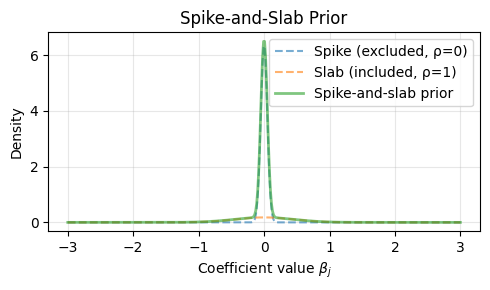

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ===== パラメータ設定 =====
pi = 0.2           # inclusion probability (π)
n = 100            # サンプルサイズ
g = 100            # Zellner's g-prior parameter
sigma_eps = 1.0    # 誤差分散 σ_ε
XTX_diag = 5.0     # X'X の代表的スケール（単純化のため1次元想定）

# Zellnerのg-priorに基づくスラブ分散
slab_var = sigma_eps**2 * g / n / XTX_diag
slab_std = np.sqrt(slab_var)

# スパイク部分：δ(0)を幅の狭い正規分布で近似
spike_std = 0.05
w = np.linspace(-3, 3, 400)

# 確率密度の計算
spike_pdf = (1 - pi) * norm.pdf(w, 0, spike_std)
slab_pdf = pi * norm.pdf(w, 0, slab_std)
spike_slab_pdf = spike_pdf + slab_pdf

# ===== 可視化 =====
plt.figure(figsize=(5, 3), dpi=100)
plt.plot(w, spike_pdf, "--", label="Spike (excluded, ρ=0)", alpha=0.6)
plt.plot(w, slab_pdf, "--", label="Slab (included, ρ=1)", alpha=0.6)
plt.plot(w, spike_slab_pdf, label="Spike-and-slab prior", linewidth=2, alpha=0.6)

plt.title("Spike-and-Slab Prior")
plt.xlabel("Coefficient value $β_j$")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 実装

Rが本家。Pythonだと更新が数年間停止しているようなパッケージばかり

[CRAN: Package bsts](https://cran.r-project.org/web/packages/bsts/index.html)

## 参考

- [Inferring causal impact using Bayesian structural time-series models](https://research.google/pubs/inferring-causal-impact-using-bayesian-structural-time-series-models/)
    - causalimpactの論文。BSTSの簡単な紹介がある
- [[R] bsts (ベイズ構造時系列モデル) パッケージの使い方 - ill-identified diary](https://ill-identified.hatenablog.com/entry/2017/09/08/001002)
- [Bayesian Structural Time Series](https://jasonlian.github.io/Rmarkdown/Tutorial_for_BSTS.html)